## Import Library

In [64]:
import os
import cv2
import json
import math
import torch
import torchvision
import numpy as np
import torch.nn as nn
from tqdm import tqdm
from PIL import ImageFile
import PIL.Image as Image
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchsummary import summary
from collections import Counter
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, f1_score
ImageFile.LOAD_TRUNCATED_IMAGES = True

## Configurations Setup

In [65]:
image_size = 224
batch_size = 32
num_workers = 8
learning_rate = 1e-4
num_epoch = 10
train_ratio = 0.7

## Load Dataset

In [66]:
data = torchvision.datasets.ImageFolder(root='./archive (1)')

### Splitting the data into train and test set

In [67]:
train_size = int(train_ratio * len(data))
test_size = len(data) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(data, [train_size, test_size])

In [68]:
train_transform = transforms.Compose([transforms.Resize((image_size, image_size)),
                                                      transforms.RandomAffine(degrees=(-90, 90),scale=(0.85, 0.95)),
                                                      transforms.ToTensor()])

test_transform = transforms.Compose([transforms.Resize((image_size, image_size)),
                                                     transforms.ToTensor()])

In [69]:
train_dataset = torch.utils.data.Subset(torchvision.datasets.ImageFolder(root='./archive (1)', transform=train_transform), train_dataset.indices)
test_dataset = torch.utils.data.Subset(torchvision.datasets.ImageFolder(root='./archive (1)', transform=test_transform), test_dataset.indices)

In [70]:
print(f"Total of Data: {len(data)}")
print(f"Training set size: {len(train_dataset)}")
print(f"Testing set size: {len(test_dataset)}")


Total of Data: 8605
Training set size: 6023
Testing set size: 2582


In [71]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=num_workers)

### Count the data that consist in each classes

In [72]:
# Function to count samples per class
def count_samples_per_class(dataset):
    labels = [label for _, label in dataset]
    label_count = Counter(labels)
    return label_count

In [ ]:
label_count = count_samples_per_class(train_dataset)
num_classes = len(label_count)
print("Total number of data: ", len(train_dataset))
print("Number of classes:", num_classes)
print("Number of data samples per class:", label_count)

d:\Program_File\anaconda3\envs\pytorch_1\Lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [40]:
label_count = count_samples_per_class(test_dataset)
num_classes = len(label_count)
print("Total number of data: ", len(test_dataset))
print("Number of classes:", num_classes)
print("Number of data samples per class:", label_count)

Total number of data:  2582
Number of classes: 11
Number of data samples per class: Counter({1: 346, 2: 292, 5: 247, 6: 246, 10: 239, 7: 224, 3: 218, 0: 211, 4: 201, 9: 196, 8: 162})


### Show sample Image with Label

In [41]:
cat_to_name = {'1':'Ant', '2':'Bee', '3': 'Bettle', '4': 'Butterfly', '5': 'Dragonfly', '6':'Fly', '7':'Grasshoper', '8':'Ladybug', '9':'Mosquito', '10':'Spider', '11':'Wasp'}
def imshow(img_tensor, ax, label):
    """ Utility function to display an image tensor with a caption. """
    if img_tensor.shape[0] == 3:  # Check if it's an RGB image
        ax.imshow(img_tensor.permute(1, 2, 0))  # Reorder dimensions to (height, width, channels)
    else:
        ax.imshow(img_tensor[0], cmap='gray')  # Display the first channel (grayscale)
    ax.axis('off')
    ax.set_title(label, fontsize=10)

def show_images_batch(images_batch, labels):
    """
    Display a batch of images in a grid with labels.
    """

    batch_size = images_batch.shape[0]
    grid_cols = int(np.ceil(np.sqrt(batch_size)))
    grid_rows = int(np.ceil(batch_size / grid_cols))  # Ensure all images fit in the grid

    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(grid_cols * 2.5, grid_rows * 2.5))
    if grid_rows * grid_cols == 1:  # Special case for single image
        axes = [axes]  # Make it iterable

    # Check if axes is still not iterable
    if not isinstance(axes, np.ndarray):
        axes = np.array([axes])


    for i in range(grid_rows * grid_cols):
        ax = axes.flatten()[i]
        if i < batch_size:
            # imshow(images_batch[i], ax, labels[i].item())
            imshow(images_batch[i], ax, cat_to_name[str(labels[i].item() + 1)])
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

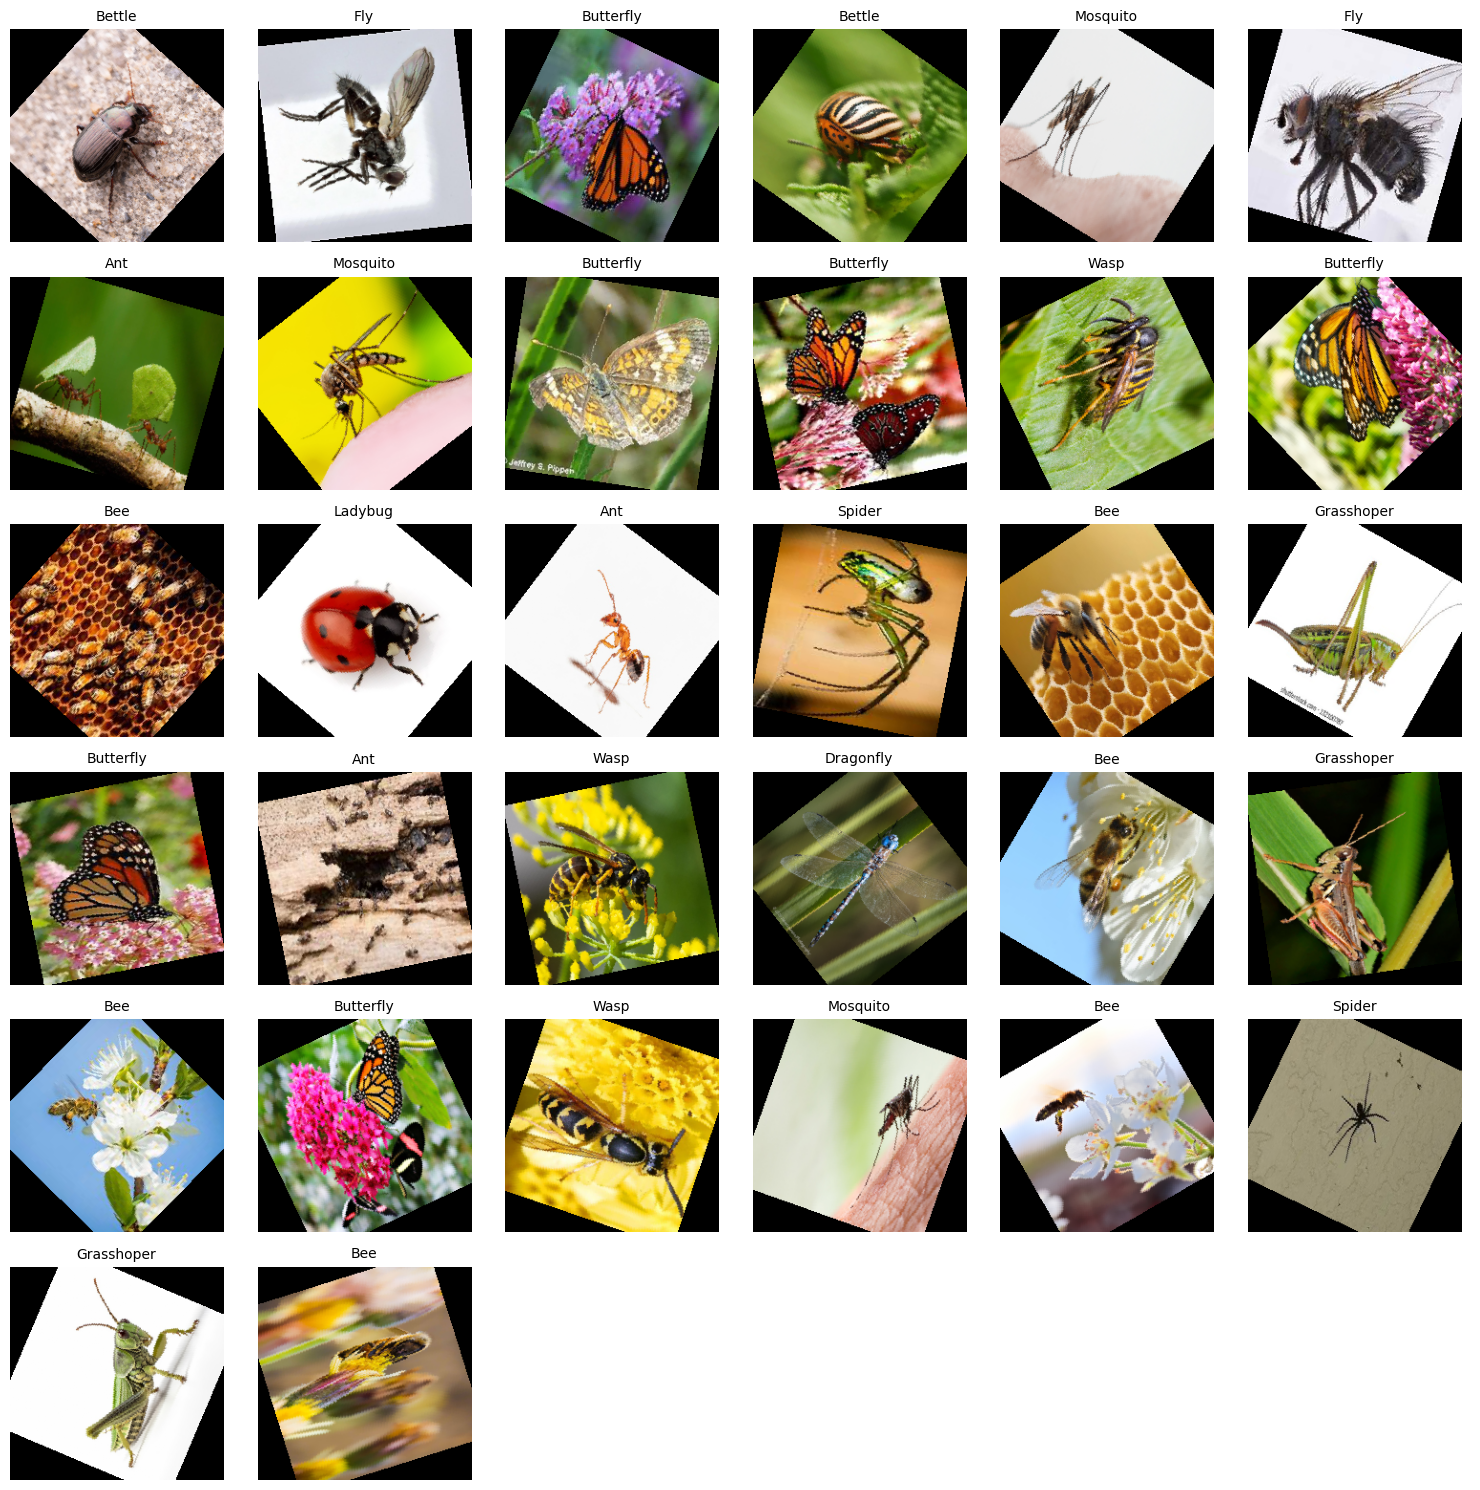

In [42]:
for idx, data in enumerate(train_loader):

  show_images_batch(images_batch=data[0], labels=data[1])
  break

## Load Model (Restnet18)

In [43]:
resnet_model = torchvision.models.resnet18().cuda()

In [44]:
for n, p in resnet_model.named_parameters():
  print(n)

conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.weight
layer2.1.bn2.weight
layer2.1.bn2.bias
layer3.0.conv1.weight
layer3.0.bn1.weight
layer3.0.bn1.bias
layer3.0.conv2.weight
layer3.0.bn2.weight
layer3.0.bn2.bias
layer3.0.downsample.0.weight
layer3.0.downsample.1.weight
layer3.0.downsample.1.bias
layer3.1.conv1.weight
layer3.1.bn1.weight
layer3.1.bn1.bias
layer3.1.conv2.weight
layer3.1.bn2.weight
layer3.1.bn2.bias
layer4.0.conv1.weight
layer4.0.bn1.weight
layer4.0.bn1.bias
layer4.0.conv2.we

In [45]:
for p in resnet_model.parameters():
  p.requires_grad = False

In [46]:
summary(resnet_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [47]:
for p in resnet_model.named_parameters():
  # print(p[0])
  if 'layer1' in p[0]:
    p[1].requires_grad = True
  if 'layer4' in p[0]:
    p[1].requires_grad = True

In [48]:
summary(resnet_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

Adjust Model Layer to fit the number of classes

In [49]:
resnet_model.fc = nn.Linear(512, 11)

In [50]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(resnet_model.parameters(), lr=learning_rate)

In [51]:
resnet_model = resnet_model.cuda()

In [52]:
train_dataset_size = len(train_dataset)

# Calculate the number of iterations per epoch
iterations_per_epoch_train = math.ceil(train_dataset_size / batch_size)

test_dataset_size = len(test_dataset)

# Calculate the number of iterations per epoch
iterations_per_epoch_test = math.ceil(test_dataset_size / batch_size)

print(f"Iterations per epoch(Train): {iterations_per_epoch_train}")
print(f"Iterations per epoch(Test): {iterations_per_epoch_test}")

Iterations per epoch(Train): 189
Iterations per epoch(Test): 81


In [53]:
train_losses = []
test_accuracies = []

In [56]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
resnet_model.to(device)

for epoch in range(num_epoch):
    resnet_model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet_model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    print(f'Epoch [{epoch+1}/{num_epoch}], Loss: {train_loss:.4f}')

    # Evaluate the resnet_model
    resnet_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)
    print(f'Test Accuracy: {accuracy:.2f}%')

Epoch [1/10], Loss: 1.8001
Test Accuracy: 47.79%
Epoch [2/10], Loss: 1.4112
Test Accuracy: 59.80%
Epoch [3/10], Loss: 1.2353
Test Accuracy: 61.35%
Epoch [4/10], Loss: 1.1103
Test Accuracy: 65.57%
Epoch [5/10], Loss: 1.0145
Test Accuracy: 67.74%
Epoch [6/10], Loss: 0.9543
Test Accuracy: 70.41%
Epoch [7/10], Loss: 0.8882
Test Accuracy: 70.60%
Epoch [8/10], Loss: 0.8428
Test Accuracy: 74.40%
Epoch [9/10], Loss: 0.7962
Test Accuracy: 72.31%
Epoch [10/10], Loss: 0.7716
Test Accuracy: 74.24%


In [25]:
# for epoch_idx in range(num_epoch):

#   train_running_loss = 0.0
#   train_running_accuracy = 0.0
#   train_losses = []
#   train_accuracy = []

#   idx = 0
#   for idx, data in tqdm(enumerate(train_loader)):

#     optimizer.zero_grad()

#     images, labels = data
#     images = images.cuda()
#     labels = labels.cuda()

#     pred = resnet_model(images)

#     loss = loss_fn(pred, labels)

#     loss.backward()
#     optimizer.step()

#     train_running_loss += loss.item()

#     _, pred_arr = torch.max(pred.detach(), 1)
#     label_arr = labels.cpu().numpy()


#     train_running_accuracy += accuracy_score(label_arr, pred_arr.cpu().numpy())
#     train_accuracy.append(accuracy_score(label_arr, pred_arr.cpu().numpy()))
#     train_losses.append(loss.item())

#   print(f"Training Loss at epoch {epoch_idx} is {train_running_loss}")
#   print(f"Training Accuracy at epoch {epoch_idx} is {train_running_accuracy/(idx+1)}")

189it [00:47,  3.99it/s]


Training Loss at epoch 0 is 347.3813627958298
Training Accuracy at epoch 0 is 0.3779998110355254


189it [00:44,  4.21it/s]


Training Loss at epoch 1 is 273.7504825592041
Training Accuracy at epoch 1 is 0.507629440665155


189it [00:46,  4.06it/s]


Training Loss at epoch 2 is 240.04473543167114
Training Accuracy at epoch 2 is 0.5717356386999244


189it [00:46,  4.05it/s]


Training Loss at epoch 3 is 212.91856211423874
Training Accuracy at epoch 3 is 0.6221419123204838


189it [00:46,  4.08it/s]


Training Loss at epoch 4 is 195.83328086137772
Training Accuracy at epoch 4 is 0.6481245275888132


189it [00:46,  4.05it/s]


Training Loss at epoch 5 is 186.38291296362877
Training Accuracy at epoch 5 is 0.6630527210884354


189it [00:49,  3.85it/s]


Training Loss at epoch 6 is 173.40368407964706
Training Accuracy at epoch 6 is 0.6904998110355253


189it [00:46,  4.05it/s]


Training Loss at epoch 7 is 163.86459556221962
Training Accuracy at epoch 7 is 0.7095379818594105


189it [00:44,  4.23it/s]


Training Loss at epoch 8 is 154.52228581905365
Training Accuracy at epoch 8 is 0.7198837868480726


189it [00:44,  4.20it/s]

Training Loss at epoch 9 is 147.07755714654922
Training Accuracy at epoch 9 is 0.7349773242630385


In [26]:
# val_running_loss = 0.0
# val_running_accuracy = 0.0
# idx = 0
# val_losses = []
# val_accuracy = []


# for idx, data in enumerate(test_loader):
#   images, labels = data
#   images = images.cuda()
#   labels = labels.cuda()

#   pred = resnet_model(images)

#   loss = loss_fn(pred, labels)

#   val_running_loss += loss.item()

#   _, pred_arr = torch.max(pred.detach(), 1)
#   label_arr = labels.cpu().numpy()

#   val_running_accuracy += accuracy_score(label_arr, pred_arr.cpu().numpy())
#   val_accuracy.append(val_running_accuracy/(idx+1))
#   val_losses.append(val_running_loss/len(test_loader))
  

# print(f"Validation Loss is {val_running_loss}")
# print(f"Validation Accuracy is {val_running_accuracy/(idx+1)}")

Validation Loss is 84.4948114156723
Validation Accuracy is 0.6474466891133558


In [ ]:
# # Plotting the learning curves for training and testing
# plt.figure(figsize=(12, 5))

# # Plot Training and Testing Loss
# plt.subplot(2, 2, 1)
# plt.plot(range(1, num_epoch + 1), train_losses, 'b', label='Training Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Training and Testing Loss')  # Updated title
# plt.legend()

# # Plot Training and Testing Accuracy
# plt.subplot(2, 2, 2)
# plt.plot(range(1, num_epoch + 1), val_accuracy, 'b', label='Testing Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.title('Training and Testing Accuracy')  # Updated title
# plt.legend()


# plt.subplot(2, 2, 3)
# plt.plot(range(1, num_epoch + 1), train_accuracy, 'b', label='Training Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.title('Training and Testing Accuracy')  # Updated title
# plt.legend()


# plt.subplot(2, 2, 4)
# plt.plot(range(1, num_epoch + 1), val_accuracy, 'r', label='Testing Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.title('Training and Testing Accuracy')  # Updated title
# plt.legend()

# plt.show()


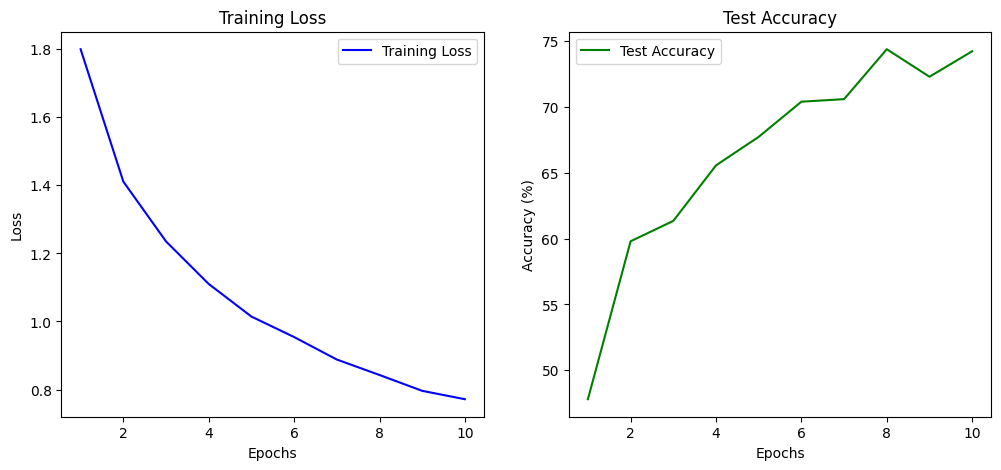

In [57]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epoch + 1), train_losses, 'b', label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epoch + 1), test_accuracies, 'g', label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')
plt.legend()

plt.show()

In [58]:
torch.save(resnet_model.state_dict(), 'restnet_trained.pth')

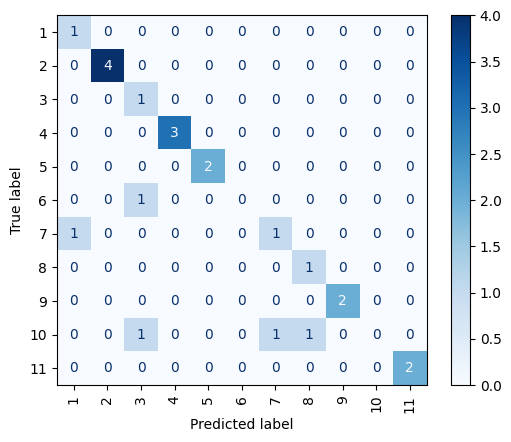

In [63]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(labels.cpu(), predicted.cpu())

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cat_to_name)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.show()

In [40]:
testing_img = Image.open("C:/Users/User/Downloads/ant.jpg")
transform = transforms.Compose([transforms.Resize((image_size, image_size)), transforms.ToTensor()])
testing_img = transform(testing_img).unsqueeze(0).cuda()
pred = resnet_model(testing_img)

probabilities = F.softmax(pred, dim=1)
predicted_class = torch.argmax(probabilities, dim=1).item()
predicted_label = cat_to_name[str(predicted_class + 1)]
print(f"Predicted class: {predicted_class}, Label: {predicted_label}")

Predicted class: 6, Label: Grasshoper
